# 암호화폐(BitCoin)의 가격 예측 모델

## 필요 모듈 설치
> pyupbit 모듈은 업비트 API를 파이썬에서 쉽게 사용하기 위해서 개발되었다. 따로 API를 호출할 필요가 없어 간편하다. 

[Github 문서](https://github.com/sharebook-kr/pyupbit)

In [21]:
!pip install pyupbit
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import pyupbit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [23]:
# 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2000, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2022-12-01 09:00:00,23209000.0,23400000.0,22871000.0,23002000.0,3278.515197,7.576107e+10
2022-12-02 09:00:00,23008000.0,23046000.0,22650000.0,22877000.0,2707.549170,6.175598e+10
2022-12-03 09:00:00,22877000.0,22973000.0,22752000.0,22830000.0,1361.730873,3.107119e+10
2022-12-04 09:00:00,22821000.0,23021000.0,22755000.0,22906000.0,1690.073993,3.866140e+10


In [24]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1898 entries, 2017-09-25 09:00:00 to 2022-12-05 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1898 non-null   float64
 1   high    1898 non-null   float64
 2   low     1898 non-null   float64
 3   close   1898 non-null   float64
 4   volume  1898 non-null   float64
 5   value   1898 non-null   float64
dtypes: float64(6)
memory usage: 103.8 KB


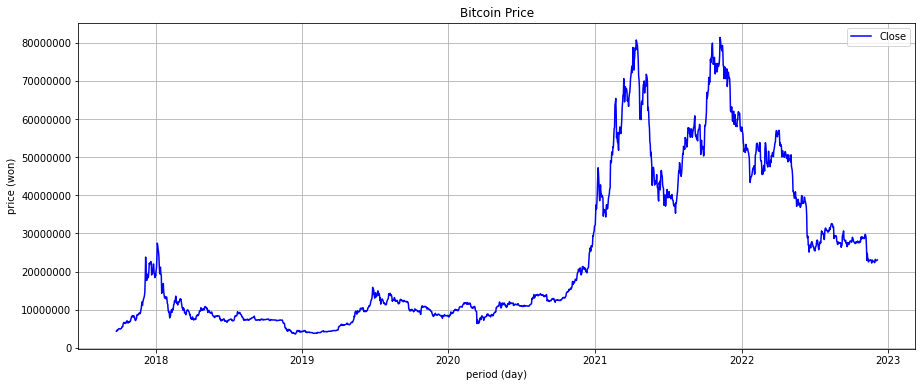

In [25]:
# 시각화
plt.figure(figsize=(15,6))

plt.title('Bitcoin Price')
plt.ylabel('price (won)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(df_origin['close'], label='Close', color='b')
plt.legend(loc='best')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values]);

In [26]:
from sklearn.preprocessing import MinMaxScaler

# 원본 복사
df = df_origin.copy()

# 정규화
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df

,open,high,low,close,volume,value
0,0.007470,0.008201,0.008021,0.009038,0.001270,0.000260
1,0.008961,0.009277,0.009800,0.009025,0.000191,0.000038
2,0.009025,0.012555,0.009892,0.013345,0.000284,0.000059
3,0.013332,0.013757,0.012522,0.012432,0.000760,0.000169
4,0.012419,0.012960,0.011959,0.013345,0.000551,0.000121
...,...,...,...,...,...,...
1893,0.251845,0.249510,0.252653,0.249190,0.032211,0.036580
1894,0.249261,0.245029,0.249761,0.247583,0.026596,0.029816
1895,0.247577,0.244106,0.251096,0.246979,0.013360,0.014996
1896,0.246857,0.244713,0.251135,0.247956,0.016589,0.018662


In [27]:
# 전처리
feature = np.array(scaled_df)
target = np.array(scaled_df[['close']])
print(feature.shape, target.shape)

(1898, 6) (1898, 1)


In [28]:
def make_seqeunce_dataset(feature, target, timesteps):
  """
  timesteps만큼의 길이로 데이터를 추출한다.
  예를들어, 일봉차트에서 50일을 추출하여여 51일째의 종가를 예측하는 식이다.
  """
  feature_lst = []
  target_lst = []

  for idx in range(len(feature)-timesteps):
    feature_lst.append(feature[idx:idx+timesteps])
    target_lst.append(target[idx+timesteps])

  return np.array(feature_lst), np.array(target_lst)

In [29]:
timesteps = 50

X, y = make_seqeunce_dataset(feature, target, timesteps)

print(X.shape, y.shape)

(1848, 50, 6) (1848, 1)


In [30]:
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1663, 50, 6) (1663, 1)
(185, 50, 6) (185, 1)


In [31]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# 모델 생성 함수
def build_model(hp):
  model = Sequential()

  hp_units = hp.Int('units', min_value=8, max_value=256, step = 8) # 노드 하이퍼 파라미터
  model.add(LSTM(units=hp_units, activation='tanh', input_shape=X_train[0].shape))

  hp_rates = hp.Float('dropout', min_value=0.05, max_value=0.5, step=0.05)  # Dropout 하이퍼 파라미터
  model.add(Dropout(rate=hp_rates))

  model.add(Dense(1, activation='linear'))

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  model.compile(
      optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), 
      loss = 'mse', 
      metrics = ['mean_absolute_percentage_error']
      )

  return model

In [32]:
import kerastuner as kt

tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = 'val_loss',
    max_epochs = 10,
    directory = 'my_dir',
    project_name = 'intro_to_kt'
)

In [33]:
import IPython

# 콜백함수 지정
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [34]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
하이퍼 파라미터 검색이 완료되었습니다. 
최적화된 첫 번째 LSTM 노드 수는 {best_hps.get('units')} 입니다.
최적의 Dropout Rate는 {best_hps.get('dropout')} 입니다.
최적의 학습 속도는 {best_hps.get('learning_rate')} 입니다.
""")


하이퍼 파라미터 검색이 완료되었습니다. 
최적화된 첫 번째 LSTM 노드 수는 24 입니다.
최적의 Dropout Rate는 0.15000000000000002 입니다.
최적의 학습 속도는 0.01 입니다.



In [35]:
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24)                2976      
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

# 최고 성능을 보이는 하이퍼파라미터 조합으로 다시 학습을 진행
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data = (X_test, y_test), callbacks=[early_stop])

Epoch 1/100
52/52 [==============================] - 6s 78ms/step - loss: 0.0071 - mean_absolute_percentage_error: 10299.4453 - val_loss: 3.2129e-04 - val_mean_absolute_percentage_error: 3.5848
Epoch 2/100
52/52 [==============================] - 2s 44ms/step - loss: 0.0020 - mean_absolute_percentage_error: 752.3243 - val_loss: 4.6125e-04 - val_mean_absolute_percentage_error: 5.0168
Epoch 3/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0019 - mean_absolute_percentage_error: 660.4297 - val_loss: 2.6599e-04 - val_mean_absolute_percentage_error: 3.3035
Epoch 4/100
52/52 [==============================] - 2s 46ms/step - loss: 0.0017 - mean_absolute_percentage_error: 7040.9272 - val_loss: 3.7620e-04 - val_mean_absolute_percentage_error: 4.9545
Epoch 5/100
52/52 [==============================] - 2s 44ms/step - loss: 0.0015 - mean_absolute_percentage_error: 408.5087 - val_loss: 2.3583e-04 - val_mean_absolute_percentage_error: 3.1505
Epoch 6/100
52/52 [==================

In [37]:
# 예측 데이터
y_pred = model.predict(X_test)

# 정규화 전 데이터로 복구
y_test_back = y_test * (df['close'].max()-df['close'].min()) + df['close'].min()
y_pred_back = y_pred * (df['close'].max()-df['close'].min()) + df['close'].min()

y_test_back_df = pd.DataFrame(y_test_back, columns=['close'], index=df.index[-y_test.shape[0]:])
y_pred_back_df = pd.DataFrame(y_pred_back, columns=['close'], index=df.index[-y_test.shape[0]:])

6/6 [==============================] - 1s 8ms/step


6/6 [==============================] - 0s 16ms/step


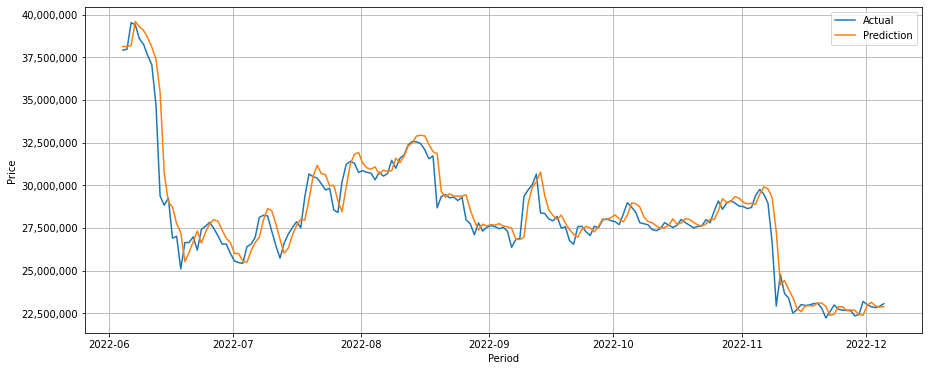

In [39]:
pred = model.predict(X_test)

plt.figure(figsize=(15,6))
plt.xlabel('Period')
plt.ylabel('Price')
plt.plot(y_test_back_df, label='Actual')
plt.plot(y_pred_back_df, label='Prediction')
plt.grid()
plt.legend(loc='best')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);